In [ ]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

<a href=https://arxiv.org/pdf/1609.03499.pdf> Wave Net</a>

In [50]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(42);
random.seed(42);

In [51]:
words = open('names.txt').read().split()
vocab = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i,ch in enumerate(vocab)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}
encode = lambda x: [stoi[i] for i in x]
decode = lambda x: ''.join([itos[i] for i in x])

In [52]:
block_size = 8
def build_data(words):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for char in word + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
Xtr, Ytr = build_data(words[:n1])
Xte, Yte =  build_data(words[n1:n2])
Xdev , Ydev = build_data(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [53]:
class Linear:
    def __init__(self, IN, OUT, bias=True):
        self.weight = torch.randn(IN, OUT) / IN ** 0.5 
        self.bias = torch.zeros(OUT) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out
            
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.momentum = momentum
        self.training = True
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if x.ndim == 2:
            dim = 0
        if x.ndim == 3:
            dim = (0,1)
        if self.training:
            xmean = x.mean(dim,keepdim=True)
            xvar = x.var(dim,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xnorm = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xnorm + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean +  self.momentum * xmean
                self.running_var = (1- self.momentum)  * self.running_var +  self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Embedding:
    def __init__(self, num_embeddding, embedding_dim):
        self.weight = torch.randn(num_embeddding, embedding_dim)
    
    def __call__(self, x):
        self.out = self.weight[x]
        return self.out
    
    def parameters(self):
        return [self.weight]

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n , C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params += layer.parameters()
        return params
    
    def eval(self):
        for layer in self.layers:
            layer.training = False
            
    def train(self):
        for layer in self.layers:
            layer.training = True
            
    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

In [54]:
n_embd = 10
n_hidden = 200
vocab_size = len(stoi)

model = Sequential([Embedding(vocab_size, n_embd), 
                    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias =False),BatchNorm1d(n_hidden), Tanh(), 
                    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias =False),BatchNorm1d(n_hidden), Tanh(), 
                    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias =False),BatchNorm1d(n_hidden), Tanh(), 
                    Linear(n_hidden, vocab_size)])

with torch.no_grad():
    model.layers[-1].weight *=0.1 # makes the initial output distribution more uniform
parameters = model.parameters()
print(sum(p.numel() for p in parameters))
for p in parameters:
    p.requires_grad = True

170897


In [14]:
ix = torch.randint(0, Xte.shape[0], (4,))
Xb , Yb = Xte[ix], Yte[ix]
logits = model(Xb)
logits.shape , Xb.shape


for layer in model.layers:
    print(layer.__class__.__name__, tuple(layer.out.shape))

Embedding (4, 8, 10)
FlattenConsecutive (4, 4, 20)
Linear (4, 4, 200)
BatchNorm1d (4, 4, 200)
Tanh (4, 4, 200)
FlattenConsecutive (4, 2, 400)
Linear (4, 2, 200)
BatchNorm1d (4, 2, 200)
Tanh (4, 2, 200)
FlattenConsecutive (4, 400)
Linear (4, 200)
BatchNorm1d (4, 200)
Tanh (4, 200)
Linear (4, 27)


In [62]:
max_steps = 100000
batch_size = 32
lossi = []
lr = 0.01
model.train()
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb , Yb = Xtr[ix], Ytr[ix]
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    #backward pass
    model.zero_grad()
    loss.backward()
    # update parameters
    for p in parameters:
        p.data -= p.grad * lr
    if i%10000==0:
        print(f". {i}/{max_steps}   : {loss.item():.4f}")
    lossi.append(loss.log10().item())

. 0/100000   : 3.2696
. 10000/100000   : 1.9866
. 20000/100000   : 1.9348
. 30000/100000   : 1.8904
. 40000/100000   : 1.9605
. 50000/100000   : 1.8128
. 60000/100000   : 1.6015
. 70000/100000   : 1.8234
. 80000/100000   : 2.4494
. 90000/100000   : 1.7458


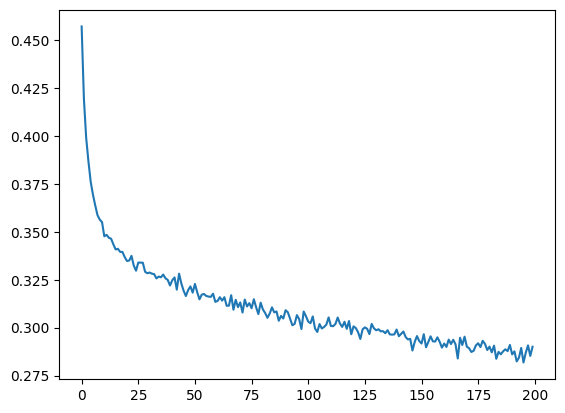

In [63]:
plt.plot(torch.tensor(lossi).view(-1,500).mean(1));

In [64]:
model.eval()
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9251469373703003
val 2.03348970413208


In [1]:
for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      # if we sample the special '.' token, break
      if ix == 0:
        break
      out.append(ix)
    print(''.join(itos[i] for i in out))

NameError: name 'block_size' is not defined

In [ ]:
# plt.figure(figsize=(20,5))
# legends = []
# for i, layer in enumerate(Layers[:-1]): # note: exclude the output layer
#   if isinstance(layer, Tanh):
#     t = layer.out
#     print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
#     hy, hx = torch.histogram(t, density=True)
#     plt.plot(hx[:-1].detach(), hy.detach())
#     legends.append(f'layer {i} ({layer.__class__.__name__}')
# plt.legend(legends);
# plt.title('activation distribution')


# # visualize histograms
# plt.figure(figsize=(20, 4)) # width and height of the plot
# legends = []
# for i,p in enumerate(parameters):
#   t = p.grad
#   if p.ndim == 2:
#     print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
#     hy, hx = torch.histogram(t, density=True)
#     plt.plot(hx[:-1].detach(), hy.detach())
#     legends.append(f'{i} {tuple(p.shape)}')
# plt.legend(legends)
# plt.title('weights gradient distribution');



# # visualize histograms
# plt.figure(figsize=(20, 4)) # width and height of the plot
# legends = []
# for i, layer in enumerate(Layers[:-1]): # note: exclude the output layer
#   if isinstance(layer, Tanh):
#     t = layer.out.grad
#     print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
#     hy, hx = torch.histogram(t, density=True)
#     plt.plot(hx[:-1].detach(), hy.detach())
#     legends.append(f'layer {i} ({layer.__class__.__name__}')
# plt.legend(legends);
# plt.title('gradient distribution')


# plt.figure(figsize=(20, 4))
# legends = []
# for i,p in enumerate(parameters):
#   if p.ndim == 2:
#     plt.plot([ud[j][i] for j in range(len(ud))])
#     legends.append('param %d' % i)
# plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
# plt.legend(legends);